# U4 - Abdullah Barhoum (5041774) - Katharina Müller (5284090)

# Assignment 4: Hough Transform

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color, filters
import numpy as np
from skimage.draw import line, circle_perimeter
import math 
from collections import defaultdict
import cv2
from tqdm import tqdm_notebook


## Ex. 4.1 Detect lanes and eyes

* there are two datasets available: "images/eye_tracking" and "images/lane_detection" - decide for one of them
* implement the classical Hough Transform for lines (for lane detection) **OR** circles (eye tracking) as shown in the lecture
* use a Canny edge detector to produce edge images for the sequence of images

Wall time: 507 ms


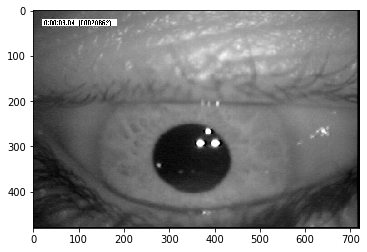

In [2]:
circle_image = io.imread('images/eye_tracking/0090.jpeg')
img_gray = color.rgb2gray(circle_image)
plt.imshow(img_gray, cmap = plt.cm.gray)

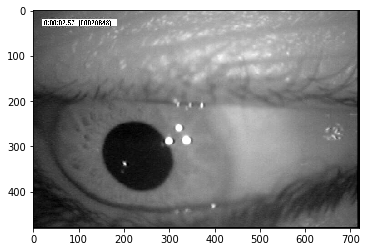

In [13]:
eye_left = io.imread('images/eye_tracking/0076.jpeg')
eye_left_gray = color.rgb2gray(eye_left)
plt.imshow(eye_left_gray, cmap = plt.cm.gray)

## OPTION 2: circle detection for eye detection
* use your implementation of the Hough Transform to find the 10 strongest circles in the image
* display your result set (draw those circles on the image) (**RESULT**)
* can you improve the performance by limiting the space of solutions? implement and draw circles again! (**BONUS**)

In [4]:
# voting:
def voting(img, h_step_size=1, w_step_size=1, r_step_size=1):
    H, W = img.shape
    R = min(H, W) // 2
    acc = np.zeros((H, W, R), np.uint32)
    for r in tqdm_notebook(range(2, R, r_step_size), leave=False):
        for y in range(r, H - r, h_step_size):
            for x in range(r, W - r, w_step_size):
                # shape = None
                # if x <= r or W - x <= r or y <= r or H - y <= r:
                    # shape = img.shape
                val = img[circle_perimeter(y, x, r, 'andres')].sum()
                if val > 0:
                    acc[y, x, r] += val
    return acc

### example on whole image

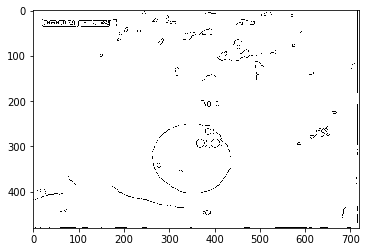

In [5]:
edges_whole = feature.canny(img_gray, sigma=1.5)
plt.imshow(edges_whole, cmap = 'binary')

In [6]:
def draw_circles(acc, img, count = 10):
    res = acc.copy()
    result_img = color.gray2rgb(img)
    for i in range(count):
        indexes = np.unravel_index(np.argmax(res), res.shape)
        y, x, r = indexes
        result_img[circle_perimeter(y, x, r, shape=img.shape)] = np.array([1, 0, 0])
        res[indexes] = 0
    return result_img

In [18]:
res_whole = voting(edges_whole)

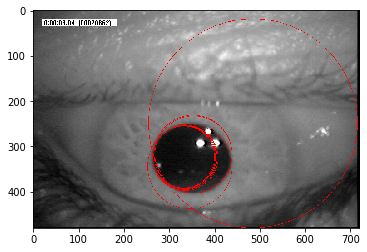

In [21]:
plt.imshow(draw_circles(res_whole, img_gray))

processing the full image took about 40 minutes

### optimize by iterating 3 pixels at once

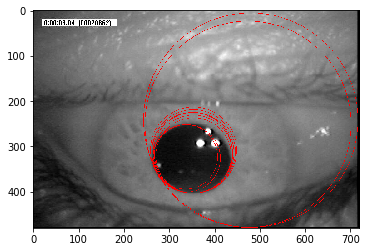

Wall time: 1min 40s


In [8]:
%%time
pixel_3 = voting(edges_whole, 3, 3, 3)
plt.imshow(draw_circles(pixel_3, img_gray))
plt.show()

### 5 pixels at once

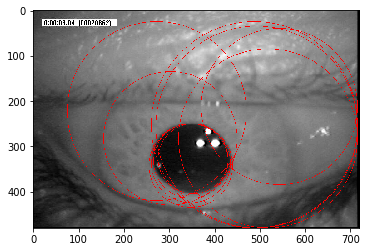

Wall time: 25.4 s


In [10]:
%%time
pixel_5 = voting(edges_whole, 5, 5, 5)
plt.imshow(draw_circles(pixel_5, img_gray))
plt.show()

### example on crop that works on all images

(220, 340)


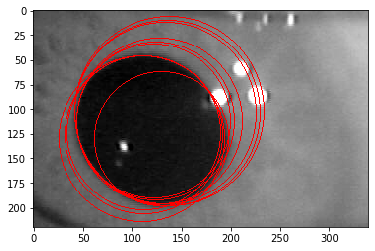

Wall time: 19.5 s


In [14]:
%%time
crop_img_2 = eye_left_gray[200:420, 110:450]
print(crop_img_2.shape)
edges = feature.canny(crop_img_2, sigma=1.5)
res = voting(edges, 2, 2, 2)
plt.imshow(draw_circles(res, crop_img_2))
plt.show()

### optimisation by cropping image further

(170, 210)


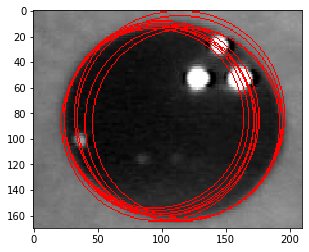

Wall time: 5.74 s


In [17]:
%%time
crop_img = img_gray[240:410, 240:450]
print(crop_img.shape)
crop_edges = feature.canny(crop_img, sigma=1.5)
crop_res = voting(crop_edges, 2, 2, 2)
plt.imshow(draw_circles(crop_res, crop_img))
plt.show()

### Test for image sequence

In [ ]:
def process_image(image):
    image_gray = color.rgb2gray(image)
    crop_img = image_gray[200:420, 110:450]
    edges = feature.canny(crop_img, sigma=1.5)
    res = voting(edges 3, 3, 3)
    #draw:
    result_img = color.gray2rgb(crop_img)
    plt.imshow(draw_circles(res, result_img))

In [ ]:
for i, image_path in enumerate(tqdm(glob.glob('./images/eye_tracking/*.jpeg'))):
    image = io.imread(image_path)
    process_image(image) #however draws result for each image in sequence

# Ex. 3.2 Generalized Hough Transform

* implement the Generalized Hough Transform as described in the lecture for localizing a given template
* find the given template (see below) and mark its location in the image "animals.png" (**RESULT**)

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import io
from skimage.filters import sobel_h, sobel_v, gaussian
from skimage.feature import canny
from skimage.color import rgb2gray
from skimage.draw import circle
import numpy as np

full_circle = 2 * np.pi


def get_theta(img, gauss_sigma):
    blurred = gaussian(img, gauss_sigma)
    g_x, g_y = sobel_v(blurred), sobel_h(blurred)
    return (np.arctan2(g_y, g_x) + full_circle) % full_circle


def edges(img, gauss_sigma):
    return canny(img, gauss_sigma).nonzero()


def create_R_table(img, num_steps, gauss_sigma=1):
    theta = get_theta(img, gauss_sigma)

    edge_y, edge_x = edges(img, gauss_sigma)
    cy, cx = edge_y.mean(), edge_x.mean()

    step_size = full_circle / num_steps
    table = {index: [] for index in range(num_steps)}
    for y, x in zip(edge_y, edge_x):
        v = (cy - y, cx - x)
        bin_index = int(theta[y, x] // step_size)
        table[bin_index].append(v)
    return table


def GHT(img, table, gauss_sigma=1):
    accumulator = np.zeros_like(img)
    H, W = accumulator.shape

    theta = get_theta(img, gauss_sigma)
    edge_y, edge_x = edges(img, gauss_sigma)
    num_steps = len(table)
    step_size = full_circle / num_steps
    for y, x in zip(edge_y, edge_x):
        bin_index = int(theta[y, x] // step_size)
        for (offset_y, offset_x) in table[bin_index]:
            cy = int(y + offset_y)
            cx = int(x + offset_x)
            if H > cy >= 0 and W > cx >= 0:
                accumulator[cy, cx] += 1

    return accumulator

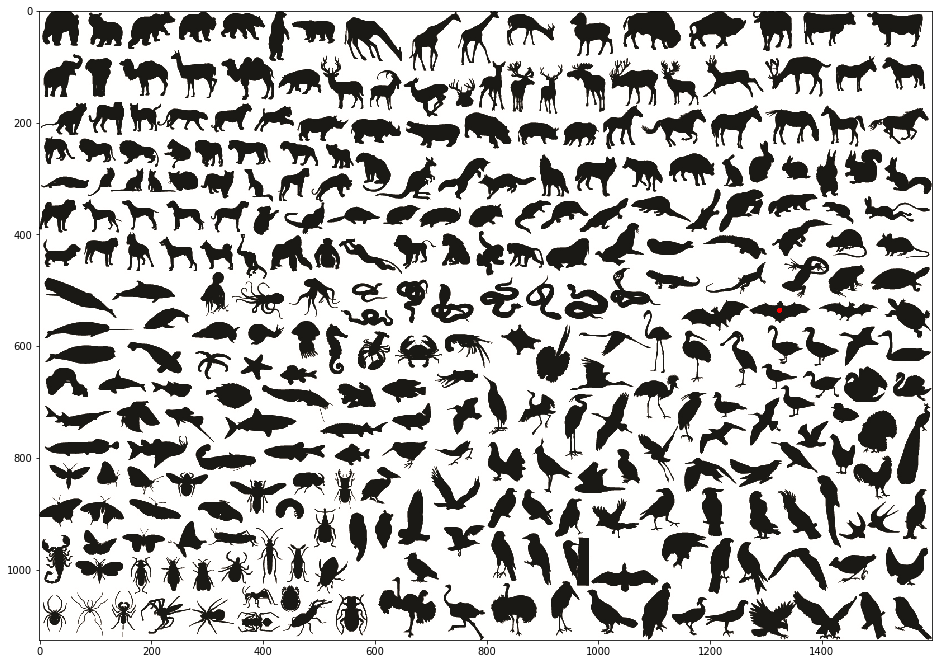

In [10]:
animals = io.imread('images/animals.png')
bat = animals[519:561, 1271:1381]

angle_steps = 180
table = create_R_table(rgb2gray(bat), angle_steps)
acc = GHT(rgb2gray(animals), table)

cy, cx = np.unravel_index(np.argmax(acc), acc.shape)
animals[circle(cy, cx, 5)] = np.array([255, 0, 0])

plt.figure(figsize=(16, 16))
plt.imshow(animals)
plt.show()

## BONUS 
* now implement an extended version of the GHT that find rotated and scaled variants of the template. 
* find Italy (see "italy.jpg") and the map of Europe ("europe_map_political.gif")
* note that you can binarize your italy template by using a simple color lookup
* draw the location of italy on the map and print its scale and orientation (**BONUS**)